In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import dca

'Tiempo de procesamiento: 10.287218103 segundos'

Nombre de campo/contrato/asignacion: SIHIL
Activo de analisis (CAMPO / CONTRATO): 
Analisis DCA Analogos (Y/''): 
Tomar muestra desde fecha (yyyy-mm-dd): 
Generar archivos (Y/''): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


'Número de pozos en SIHIL: 38'

,produccion_mensual_campo_Mbd
fecha,
2012-11-01,110.40


pozos_perforados                  38.00
pozos_productores                 36.00
pozos_secos                        2.00
exito_mecanico                     0.95
EUR_por_pozo_MMb                   6.12
pozos_activos                     20.00
pozos_cerrados                    16.00
produccion_mensual_media_Mbd       1.57
produccion_mensual_max_MMb        18.24
EUR_max_MMb                       25.66
Q_base                            24.35
Qg_base                           15.00
Qc_base                            0.00
Np                               229.63
Gp                                98.62
Cp                                 0.00
Wp                                74.29
OOIP                           1,461.64
Fr_aceite                          0.16
OGIP                             436.24
Fr_gas                             0.23
Name: SIHIL, dtype: float64

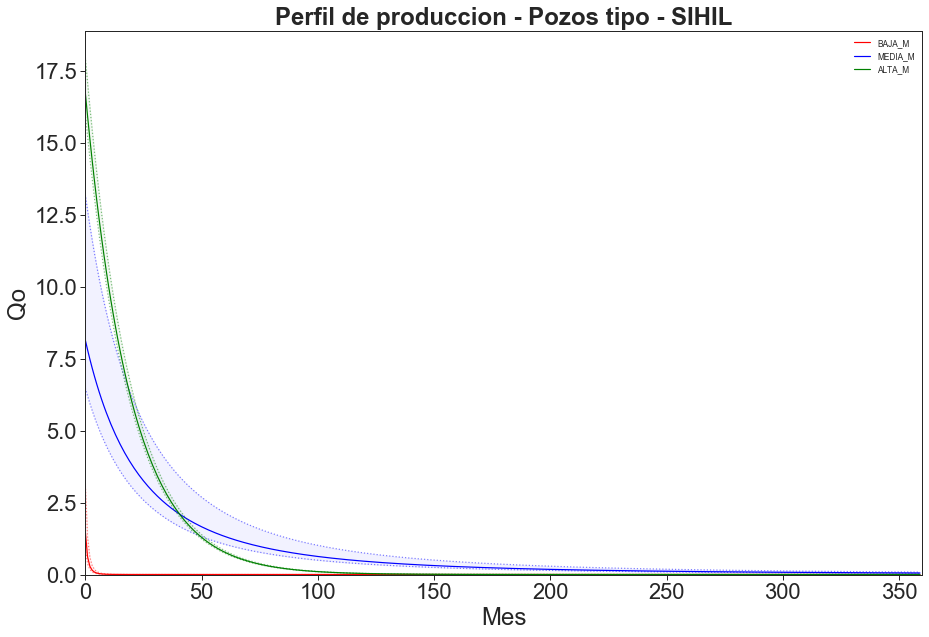

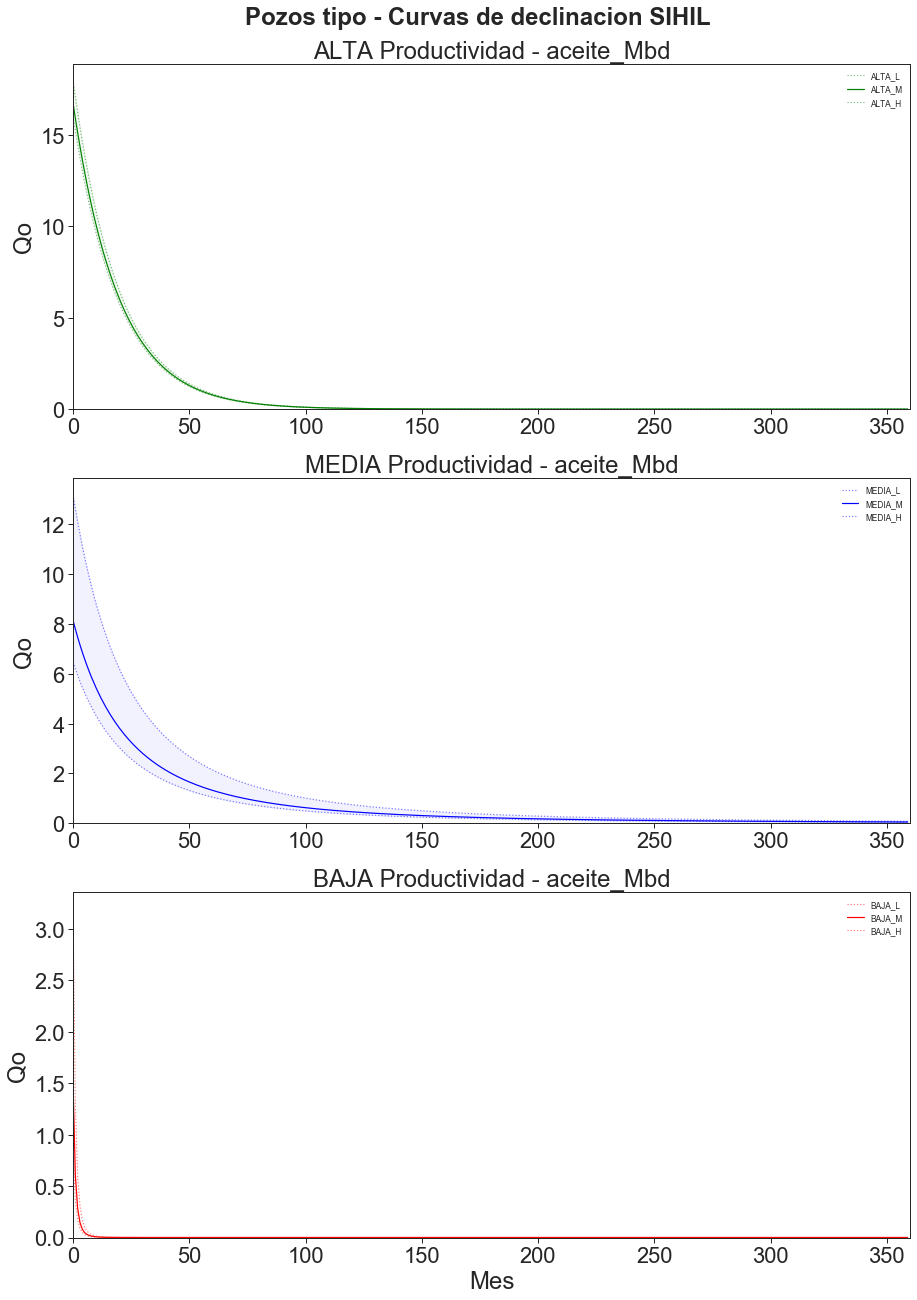

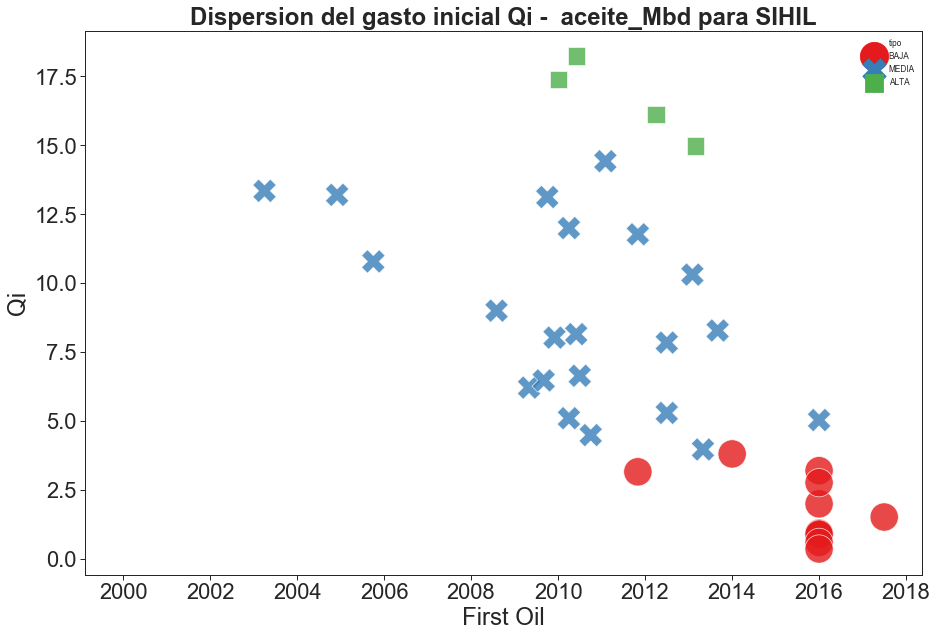

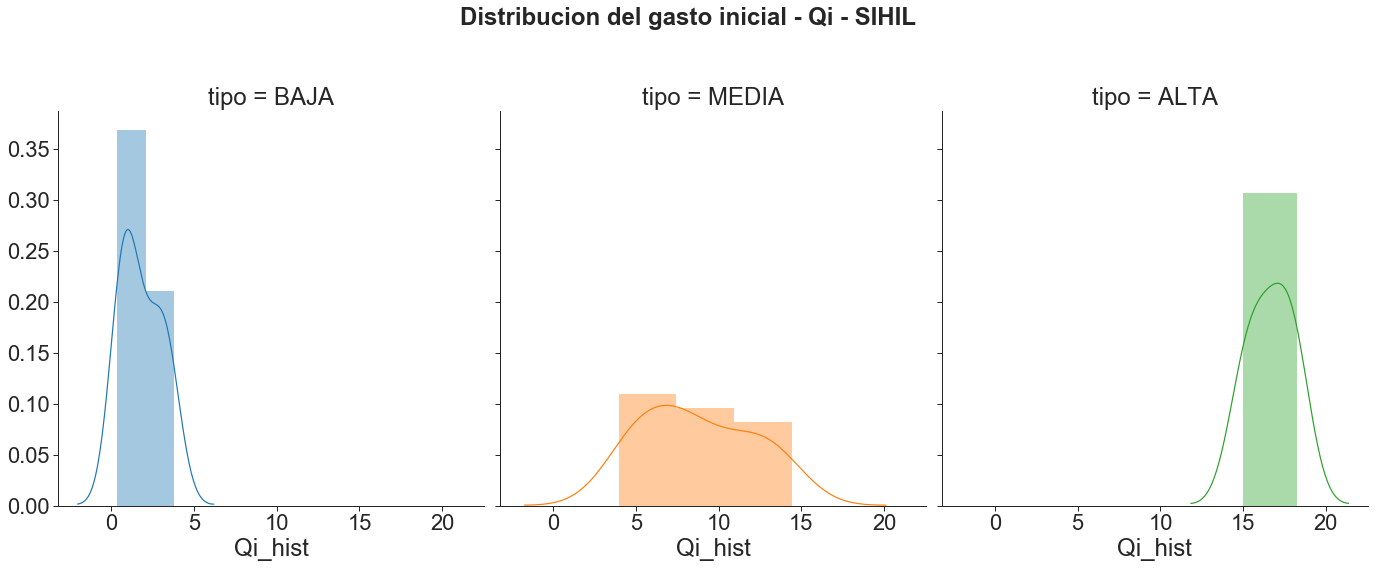

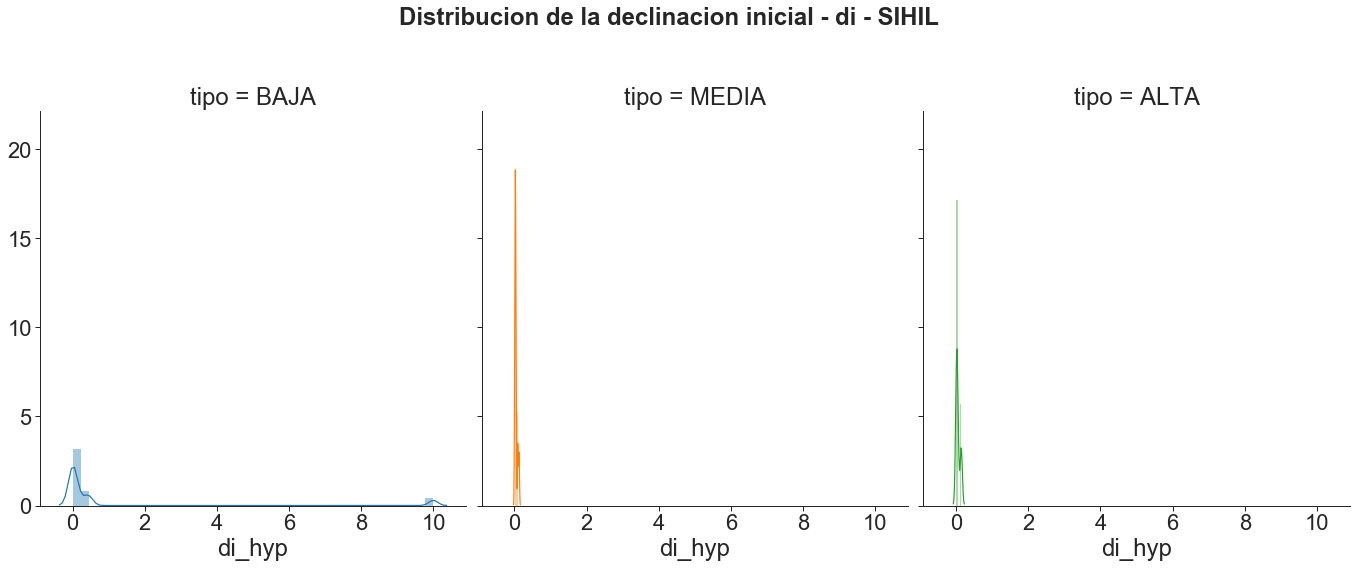

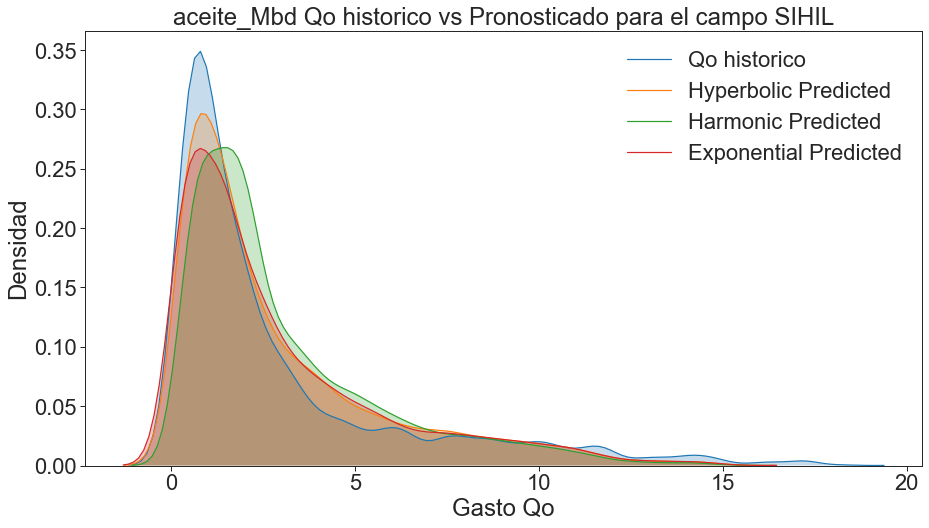

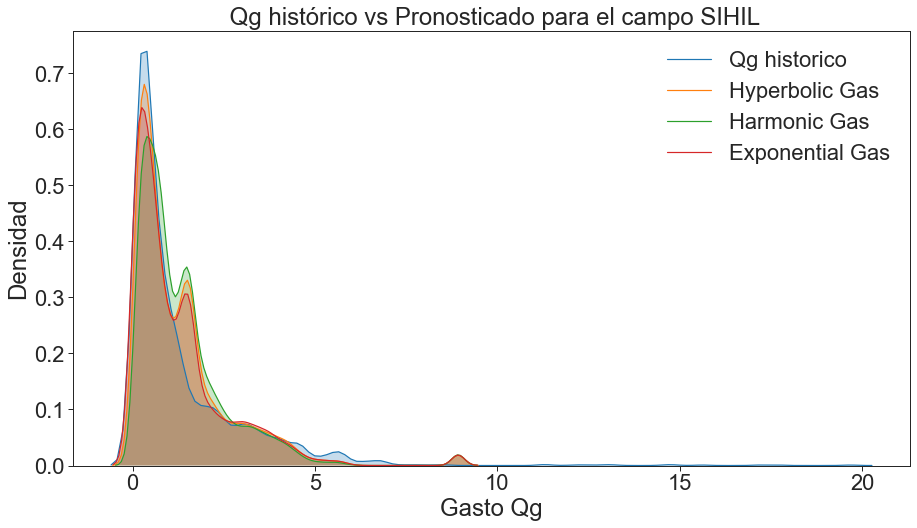

'Tiempo de procesamiento: 34.004852657 segundos'

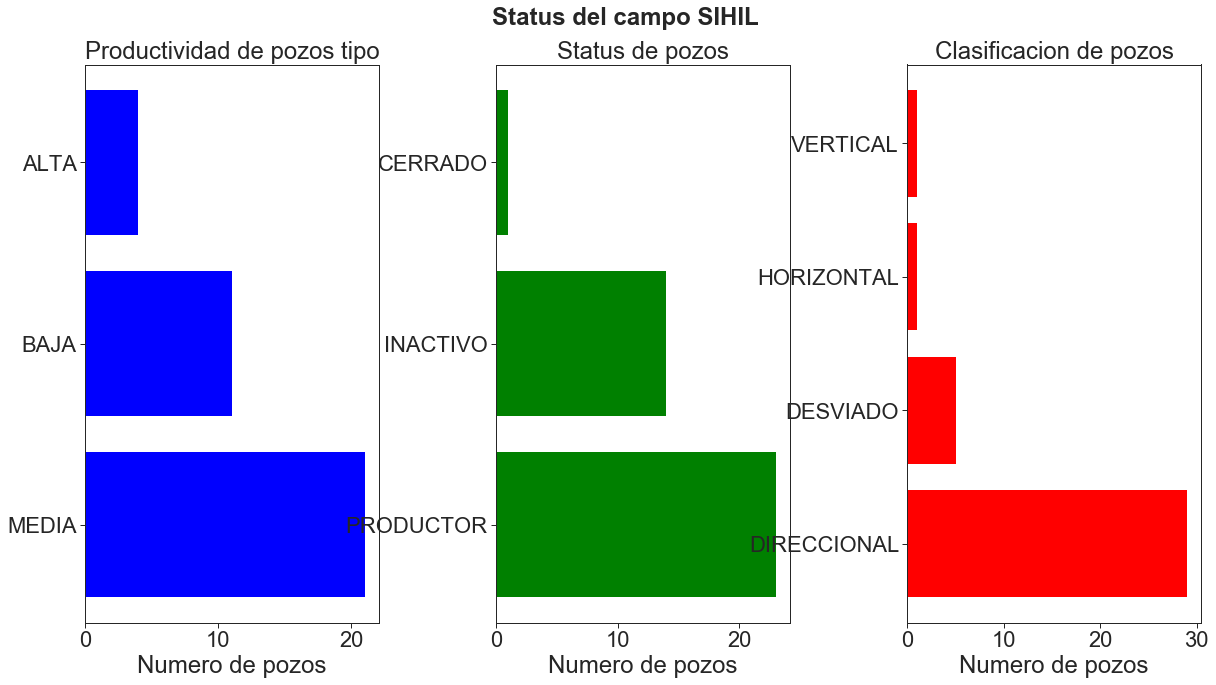

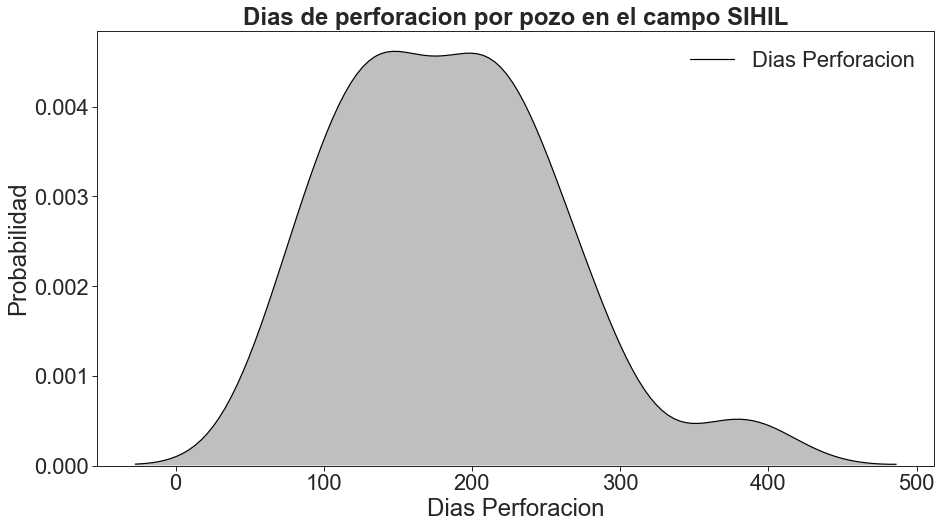

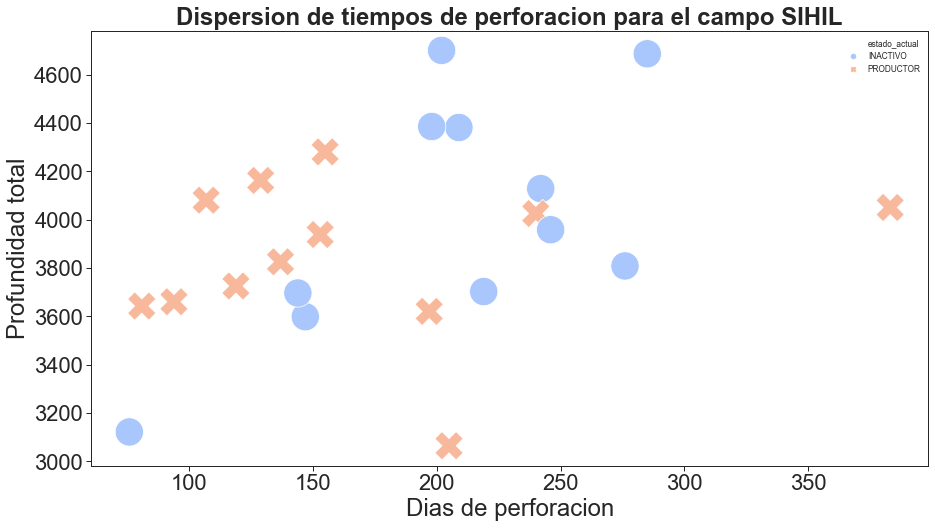

In [2]:
dca.run_dca()

In [3]:
from dca import *

In [10]:
display(perfil.columns)
display(perfil.index)

Index(['fecha', 'baja_L', 'baja_M', 'baja_H', 'media_L', 'media_M', 'media_H', 'alta_L', 'alta_M', 'alta_H'], dtype='object')

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            350, 351, 352, 353, 354, 355, 356, 357, 358, 359], dtype='int64', name='mes', length=360)

In [ ]:
display(serie_resumen.describe())

# Funcion Producción

In [ ]:
global produccion

########### DECLINACION DE LA BASE

pt=parametros.reset_index()

def seleccion_curva(pt):
    
    curve=["harm"]*(pt.index.max()+1)
    curve=pd.DataFrame(curve)
    curve.loc[pt.loc[:,"error_di_hyp"]<pt.loc[:,"error_di_harm"]]="hyp" 
    curve=curve.rename(columns={0:"type"})
    
    return curve 

curve_type=seleccion_curva(pt)
pt=pd.concat([pt,seleccion_curva(pt)],axis=1)
pt=pd.concat([pt,pd.DataFrame({"tp":[10,10,10]})],axis=1)

display(pt)

fecha=0
fecha=pd.date_range(start="2020-01-31", periods=len_proy,freq="M").to_pydatetime().tolist()
welltype=pd.DataFrame({"q0":[100,150,75],"a":[.05,.05,.1],"tp":[10,20,5],"b":[1,2,1],"type":["exp","hyp","hyp"]})


drillorder=pd.Series(np.arange(0,num_pozos))

m=0

for m in range(0,num_pozos):

    if m < pozos_tipo3:
        drillorder[m]=2
    else:
        if (m >= pozos_tipo3) & (m < (pozos_tipo2+pozos_tipo3)):
            drillorder[m]=1
        else:
            drillorder[m]=0

welltype=pt

m=0
base=pd.DataFrame()

for m in range(0,len_proy):

    base_aceite=Q_base/((1.0+welltype.b.mean()*welltype.di_hyp.mean()*m)**(1.0/welltype.b.mean()))   
    base_gas=G_base/((1.0+welltype.b_gas.mean()*welltype.di_gas.mean()*m)**(1.0/welltype.b_gas.mean()))
    base_condensado=C_base/((1.0+welltype.b_condensado.mean()*welltype.di_condensado.mean()*m)**(1.0/welltype.b_condensado.mean()))
    
    base=base.append([[m,base_aceite,base_gas,base_condensado]])

base=base.rename(columns={0:'mes',1:'aceite',2:'gas',3:'condensado'})
base=base.set_index('mes')

base.to_csv(r'/Users/fffte/Desktop/produccion_base.csv')


In [ ]:
base.plot()

# Funcion Plan de desarrollo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.signal import find_peaks
import scipy.stats

############################ FUNCIONES

def seleccion_curva(pt):
    
    curve=["harm"]*(pt.index.max()+1)
    curve=pd.DataFrame(curve)
    curve.loc[pt.loc[:,"error_di_hyp"]<pt.loc[:,"error_di_harm"]]="hyp" 
    curve=curve.rename(columns={0:"type"})
    
    return curve 

def exp_curve(welltype,t):
    if t-welltype.tp>=0:
        x=welltype.Qi*np.exp(-1*welltype.di_hyp*(t-welltype.tp))
        return x
    else:
        x=0
        return x

def exp_curve_gas(welltype,t):
    if t-welltype.tp>=0:
        x=welltype.Qi_gas*np.exp(-1*welltype.di_gas*(t-welltype.tp))
        return x
    else:
        x=0
        return x

def hyperbolic_curve(welltype,t):

    if t-welltype.tp>=0:
        if welltype.type=="harm":
            x=welltype.Qi_harm/((1.0+welltype.di_harm*(t-welltype.tp)))
        else:
            x=welltype.Qi_hyp/((1.0+welltype.b*welltype.di_hyp*(t-welltype.tp))**(1.0/welltype.b))   
        return x
    else: 
        x=0
        return x 

def hyperbolic_curve_gas(welltype,t):

    if t-welltype.tp>=0:
        if welltype.type=="harm":
            x=welltype.Qi_gas/((1.0+welltype.di_gas*(t-welltype.tp)))
        else:
            x=welltype.Qi_gas/((1.0+welltype.b_gas*welltype.di_gas*(t-welltype.tp))**(1.0/welltype.b_gas))   
        return x
    else: 
        x=0
        return x 

def hyperbolic_curve_condensado(welltype,t):

    if t-welltype.tp>=0:
        if welltype.type=="harm":
            x=welltype.Qi_condensado/((1.0+welltype.di_condensado*(t-welltype.tp)))
        else:
            x=welltype.Qi_condensado/((1.0+welltype.b_condensado*welltype.di_condensado*(t-welltype.tp))**(1.0/welltype.b_condensado))   
        return x
    else: 
        x=0
        return x     

def dec_curve(welltype,t):
    if welltype.type=="exp":
        return exp_curve(welltype,t)
    else:
        return hyperbolic_curve(welltype,t)

def dec_curve_gas(welltype,t):
    if welltype.type=="exp":
        return exp_curve_gas(welltype,t)
    else:
        return hyperbolic_curve_gas(welltype,t)

def dec_curve_condensado(welltype,t):
    if welltype.type=="exp":
        return exp_curve_condensado(welltype,t)
    else:
        return hyperbolic_curve_condensado(welltype,t)


#Perfil de produccion
def np_perf(perf,welltype,len_proy):
        for i in perf:
            Np=Np+[dec_curve(welltype,x-i) for x in Np.index]
            Np[Np<0]=0
        return(Np)
    
###perfil con plan de desarrollo    
def np_func_conplan(welltype,plan_desarrollo,base,fechas,cap=500,reservas=1000000):
    len_proy=len(fechas)
    t=range(0,len_proy)
    perf=[]
    Np=base  
    drill_order=plan_desarrollo.pozo_tipo
    perf=[]
    pozo_db=pd.Series(0,range(0,len(fechas)))
    pozo_db=pd.DataFrame(pozo_db)
    for j in plan_desarrollo.inicio_perforacion:
        t=len(fechas)-len(pd.date_range(start=j,end=fechas.max(),freq="M"))
        perf.append(t)
        
    Np_trial=pd.Series(Np)
    i=0
    for j in perf:
        ind_welltype=drill_order.loc[i]
        pozo=pd.Series([dec_curve(welltype.loc[ind_welltype,:],x-j) for x in Np_trial.index])
        Np_trial=Np_trial+pozo
        Np_trial[Np_trial<0]=0
        pozo=pd.DataFrame(pozo)
        pozo_db=pd.concat([pozo_db,pozo],ignore_index=True,axis=1)
        i=i+1
    Np=Np_trial    
    Np[np.cumsum(Np*30)>=reservas]=0
    incremental=Np-base 
    Np=pd.DataFrame(Np)
    Np=pd.concat([Np,base,incremental],axis=1,ignore_index=True)
    Np.columns=["Np","base","incremental"]
    Np.index=fechas
    pozo_db=pozo_db.loc[:,1:].set_index(fechas)
    pozo_db.columns=drill_order.loc[:i]
    fecha_perf=[fechas[x] for x in perf]
    fecha_perf=[x.strftime('%Y-%m-%d') for x in fecha_perf]
    return[Np,fecha_perf,pozo_db]


##PerfiL sin plan de desarrollo
## Modelo tren perforacion
def np_func_sinplan(welltype,plan_desarrollo,base,fechas,nequip=1,cap=500,reservas=1000000):
    len_proy=len(fechas)
    t=range(0,len_proy)
    perf=[]
    Np=base
    drillorder=plan_desarrollo.loc[:,"pozo_tipo"]
    equipdisp=np.ones((nequip,len_proy),dtype=int)
    nwells=len(drillorder)
    w=0
    pozo_db=pd.Series(0,range(0,len(fechas)))
    pozo_db=pd.DataFrame(pozo_db)
    ind_welltype=drillorder[w]
    for j in range(0,len(t)):
        
        if w>=nwells:
            break
        ind_welltype=drillorder[w]
        
        if all(equipdisp[:,j]==0):
            next 
        while (any(equipdisp[:,j]==1) and len(perf)<nwells):
            Np_trial=pd.Series(Np)
            pozo=pd.Series([dec_curve(welltype.loc[ind_welltype,:],x-j) for x in Np_trial.index])
            Np_trial=Np_trial+pozo
            Np_trial[Np_trial<0]=0
            if Np_trial.max()>=cap:
                break 
            pozo=pd.DataFrame(pozo)
            pozo_db=pd.concat([pozo_db,pozo],ignore_index=True,axis=1)
            Np=pd.Series(Np_trial)
            tp=welltype.iloc[ind_welltype,:].tp.astype(int)
            equipdisp[np.min(np.where(equipdisp[:,j]==1)),j:j+tp]=0
            perf.append(j)
            w=w+1
    Np[np.cumsum(Np*30)>=reservas]=0
    incremental=Np-base
    Np=pd.DataFrame(Np)
    Np=pd.concat([Np,base,incremental],axis=1,ignore_index=True)
    pozo_db=pozo_db.loc[:,1:].set_index(fechas)
    pozo_db.columns=drillorder[:w]
    Np.columns=["Np","base","incremental"]
    Np.index=fechas
    fecha_perf=[fechas[x] for x in perf]
    fecha_perf=[x.strftime('%Y-%m-%d') for x in fecha_perf]
    return[Np,fecha_perf,pozo_db]



def np_perfil(welltype,plan_desarrollo,fechas,base=None,nequip=1,cap=500,reservas=1000000):
    if base is None:
        base=pd.Series(0,index=fechas)
    if any(pd.isna(pd.Series(plan_desarrollo.inicio_perforacion))):
        x=np_func_sinplan(welltype,plan_desarrollo,base,fechas,nequip,cap,reservas)
    else:
        x=np_func_conplan(welltype,plan_desarrollo,base,fechas,cap,reservas)
    return x



def etapa(Np,method=1,calibracion=0.025):
    etapa=pd.Series(0,index=Np[0].index)
    inc=Np[0]["incremental"] 
    x=pd.Series(Np[0]["incremental"]).rolling(window=12).mean()
    if method==1:
        x=np.diff(x)
        x=pd.Series(x).rolling(window=12).mean()
        peaks=find_peaks(x)[0]
        peaks=int(peaks[0])
        lows=find_peaks(x*-1)[0]
        lows=int(lows[-1])
    else:
        x=np.diff(x)/x[:len(x)-1]
        peaks=np.where(x<=calibracion)[0][0]
        lows=find_peaks(x*-1)[0]
        lows=int(lows[-1])
    etapa[(peaks+1):(lows+1)]=1
    etapa[lows+1:]=2
    g1=plt.plot(inc[:peaks+1],color="m")
    g2=plt.plot(inc[peaks+1:lows+1],color="g")
    g3=plt.plot(inc[lows+1:],color="b")
    plt.title("Etapas de Produccion")
    plot=plt.show([g1,g2,g3])
    return etapa,plot


############################ COSTOS


def capex_fijo(costo_total,fecha_inicial,fecha_final,fecha_maximo=None):
    fecha=pd.date_range(start=fecha_inicial,end=fecha_final,freq="M")
    if (fecha_maximo is None):
        pagos=costo_total/len(fecha)
        desembolso=pd.Series(pagos,index=fecha)
    else:
            desembolso=pd.Series(0,index=fecha).astype(float)
            base=len(desembolso)-1
            midpoint=[x==fecha_maximo for x  in fechas].index(True)   
            c=midpoint/base
            for i in range(1,len(desembolso)+1):
                desembolso[i-1]=float(costo_total)*(scipy.stats.triang.cdf(i,c,scale=base)-scipy.stats.triang.cdf(i-1,c,scale=base))
    return desembolso


def opex_fijo(costo_mensual,fecha_inicial,fecha_final):
    fechas=pd.date_range(start=fecha_inicial,end=fecha_final,freq="M")
    desembolso=pd.Series(costo_mensual,index=fechas)
    return desembolso




def capex_fijo_estudios(fecha_inicial,fecha_final,lista_costos,lista_fechas):
    fechas=pd.date_range(start=fecha_inicial,end=fecha_final,freq="M").tolist
    lista_costos=pd.Series(lista_costos,index=lista_fechas)
    desembolso=pd.Series(0,index=fechas).astype(float)
    for i in range(0, len(lista_costos)):
        desembolso.loc[lista_costos.index[i]]=lista_costos[i]
    return desembolso    
    
    
def ag_costos(df,dates):
    capex=pd.Series(0,index=dates) 
    opex=pd.Series(0,index=dates) 
    capex=pd.DataFrame(capex)
    opex=pd.DataFrame(opex)
    for i in range(0,len(df)):
        capex=pd.DataFrame(capex)
        opex=pd.DataFrame(opex)
        capex_aux=capex_fijo(costo_total=df.iloc[i,1],fecha_inicial=df.iloc[i,2],fecha_final=df.iloc[i,3],
                   fecha_maximo=df.iloc[i,4])
        capex_aux=pd.DataFrame(capex_aux)
        capex=capex.merge(capex_aux,how="left",left_index=True,right_index=True).sum(axis=1)
        opex_aux=opex_fijo(df.iloc[i,5],df.iloc[i,3],dates.max())
        opex_aux=pd.DataFrame(opex_aux)
        opex=opex.merge(opex_aux,how="left",left_index=True,right_index=True).sum(axis=1)
    return [capex,opex]


def capex_opex_pozo(costos,opex_base,Np):
    fechas=Np[0].index
    inicio_perf=Np[1]
    fin_perf=[]
    i=0
    for w in Np[2].max():
        y=Np[2].iloc[:,i]==w
        y=y[y==True].index
        y=y.date[0]
        fin_perf.append(y)
        i=i+1
    base=Np[0]["base"]
    vec_opex_base=base*opex_base
    pozos=Np[2]
    opex_pozos=pozos
    welltype=pozos.columns
    capex=pd.Series(0,index=fechas)
    for i in range(0,len(pozos.columns)):
        opex_pozos.iloc[:,i]=opex_pozos.iloc[:,i]*costos.iloc[welltype[i],1]
    for j in range(0,len(inicio_perf)):
        daterange=pd.date_range(inicio_perf[j],fin_perf[j],freq="M")
        daterange=daterange[:-1]
        x=costos.iloc[welltype[j],0]/len(daterange)
        capex_aux=pd.Series(0,index=fechas)
        capex_aux.loc[daterange]=x
        capex=pd.concat([capex,capex_aux],ignore_index=True,axis=1)
    capex=capex.loc[:,1:]
    capex.columns=pozos.columns
    return[vec_opex_base,opex_pozos.sum(axis=1),opex_pozos,capex.sum(axis=1),capex]    

    



def costdecline_learning(Np,etapa,plateau_basebd=100,Qo_hist=0,LR=0):

    prod=Np[0]["incremental"]
    prod_base=Np[0]["base"]
    dias_mes=Np[0].index.day
    
    prod_mensual=prod*dias_mes
    Q_acum=prod_mensual.cumsum()
    if LR==0:
        b=0
    else:
        b=-1*np.log((1-LR))/np.log(2)   
    
    learningdiscount=(Q_acum/prod_mensual[find_peaks(prod_mensual)[0][1]])**(-1*b)
    
    plateau_prodmean=prod[np.where(etapa[0]==1)[0]].mean()
    decline_costos=pd.Series(0,index=Np[0].index)
    decline_costos[np.where(etapa[0]==0)[0]]=np.where(etapa[0]==0)[0]/np.where(etapa[0]==0)[0].max()
    decline_costos[np.where(etapa[0]==1)[0]]=1
    decline_costos[np.where(etapa[0]==2)[0]]=plateau_prodmean/prod[np.where(etapa[0]==2)[0]]
    
    costos_incremental=learningdiscount*decline_costos
    costos_base=learningdiscount*(plateau_basebd/prod_base)
    g1=plt.plot(costos_incremental)
    g2=plt.plot(costos_base)
    return costos_incremental,costos_base,plt.show(g1,g2)


############################ EJECUCION

########### DECLINACION DE LA BASE



pt=parametros.reset_index()
curve_type=seleccion_curva(pt)
pt=pd.concat([pt,seleccion_curva(pt)],axis=1)
pt=pd.concat([pt,pd.DataFrame({"tp":[10,10,10]})],axis=1)


fechas=0
fechas=pd.date_range(start="2020-01-31", periods=len_proy,freq="M").to_pydatetime()
welltype=pd.DataFrame({"q0":[100,150,75],"a":[.05,.05,.1],"tp":[10,20,5],"b":[1,2,1],"type":["exp","hyp","hyp"]})


drillorder=pd.Series(np.arange(0,num_pozos))

m=0

for m in range(0,num_pozos):

    if m < pozos_tipo3:
        drillorder[m]=2
    else:
        if (m >= pozos_tipo3) & (m < (pozos_tipo2+pozos_tipo3)):
            drillorder[m]=1
        else:
            drillorder[m]=0

welltype=pt

m=0
base=pd.DataFrame()

for m in range(0,len_proy):

    base_aceite=Q_base/((1.0+welltype.b.mean()*welltype.di_hyp.mean()*m)**(1.0/welltype.b.mean()))   
    base_gas=G_base/((1.0+welltype.b_gas.mean()*welltype.di_gas.mean()*m)**(1.0/welltype.b_gas.mean()))
    base_condensado=C_base/((1.0+welltype.b_condensado.mean()*welltype.di_condensado.mean()*m)**(1.0/welltype.b_condensado.mean()))
    
    base=base.append([[m,base_aceite,base_gas,base_condensado]])

base=base.rename(columns={0:'mes',1:'aceite',2:'gas',3:'condensado'})
base=base.set_index('mes')

base.to_csv(r'/Users/fffte/Desktop/produccion_base.csv')

  


########### PLAN DE DESARROLLO
       
plan_desarrollo=({"pozo_tipo":[0,1,1,1,1,1,1,1,0,1,1],
                  "inicio_perforacion":[datetime.date(2020,1,31),
                                        datetime.date(2020,1,31),
                                        datetime.date(2020,3,30),
                                        datetime.date(2020,6,30),
                                        datetime.date(2020,11,30),
                                        datetime.date(2021,1,31),
                                        datetime.date(2021,3,30),
                                        datetime.date(2021,6,30),  
                                        datetime.date(2022,1,31),
                                        datetime.date(2022,3,30),
                                        datetime.date(2022,6,30),
                                        ]})

plan_desarrollo=pd.DataFrame(plan_desarrollo) 


display(plan_desarrollo)

In [ ]:
Np_LS=np_perfil(welltype,plan_desarrollo,fechas,base,nequip=1,cap=500,reservas=1000000)
plt.plot(Np_LS[0]["Np"])
plt.title("Producción BD")

etapas=etapa(Np_LS,method=2,calibracion=0.15)


capex_opex_perforacion=pd.DataFrame({"fijos":[3.515,1.6,0],
                                     "por_barril":[3.5,3.5,3.5]})
opex_base=3.5

print(capex_opex_perforacion)


costos=capex_opex_pozo(capex_opex_perforacion,opex_base,Np_LS)
c1=plt.plot(costos[0])
c2=plt.plot(costos[1])
plt.title("Opex Pozos Incremental y Base")
plt.show([c1,c2])

c3=plt.plot(costos[3])
plt.title("Capex Pozos")
plt.show(c3)

###Costo de Instalaciones
instalaciones=capex_fijo(14.46,fecha_inicial=datetime.date(2020,1,31),
                         fecha_final=datetime.date(2038,12,31),fecha_maximo=datetime.date(2030,1,31))

mantenimiento_instalaciones=opex_fijo(.18,fecha_inicial=fecha_inicio,fecha_final=fecha_fin)

gastos_administracion=Np_LS[0]["Np"]*.50/1000

plt.plot(instalaciones)
plt.title("Capex Instalaciones")

costdecline_learning(Np=Np_LS,etapa=etapas,plateau_basebd=100,Qo_hist=0,LR=0.03)


################# RUN DEMO


def demo():
    

    tic=timeit.default_timer()

    productividad()
    perforacion()
    economico(regimen_fiscal ,regalia_adicional, region_fiscal)

    toc=timeit.default_timer()
    tac= toc - tic

    display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return